In [2]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, subplots
from ts_functions import HEIGHT, split_dataframe

file_tag = 'set2'
index_col='date'
target = 'QV2M'
data = read_csv('datasets/time_drought.csv', index_col='date', sep=',', decimal='.', parse_dates=True)
data.to_csv('before2')
data.sort_index(inplace=True)
data.to_csv('after2')


data.drop('PRECTOT', axis=1, inplace=True)
data.drop('PS', axis=1, inplace=True)
data.drop('T2M', axis=1, inplace=True)
data.drop('T2MDEW', axis=1, inplace=True)
data.drop('T2MWET', axis=1, inplace=True)
data.drop('TS', axis=1, inplace=True)



In [ ]:
def split_dataframe(data, trn_pct=0.70):
    trn_size = int(len(data) * trn_pct)
    df_cp = data.copy()
    train: DataFrame = df_cp.iloc[:trn_size, :]
    test: DataFrame = df_cp.iloc[trn_size:]
    return train, test

train, test = split_dataframe(data, trn_pct=0.75)


def plot_forecasting_series(trn, tst, prd_trn, prd_tst, figname: str, x_label: str = 'time', y_label:str =''):
    _, ax = subplots(1,1,figsize=(5*HEIGHT, HEIGHT), squeeze=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(figname)
    ax.plot(trn.index, trn, label='train', color='b')
    ax.plot(trn.index, prd_trn, '--y', label='train prediction')
    ax.plot(tst.index, tst, label='test', color='g')
    ax.plot(tst.index, prd_tst, '--r', label='test prediction')
    ax.legend(prop={'size': 5})


measure = 'R2'
flag_pct = False
eval_results = {}

### Simple Average

{'SimpleAvg': -0.01301511571547831}
{'RMSE': [4.696699116032587, 4.662218620338201], 'MAE': [4.0808530583534, 4.0412353739545965]} {'R2': [0.0, -0.01301511571547831]}


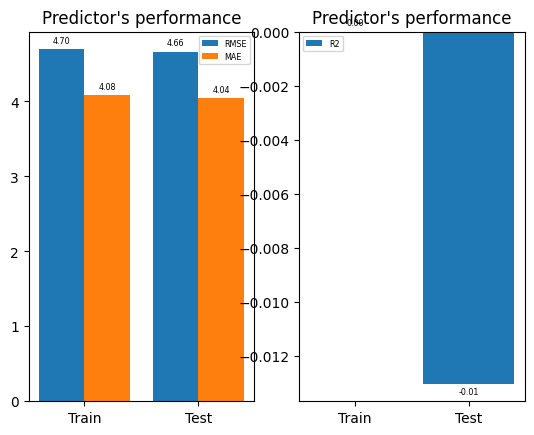

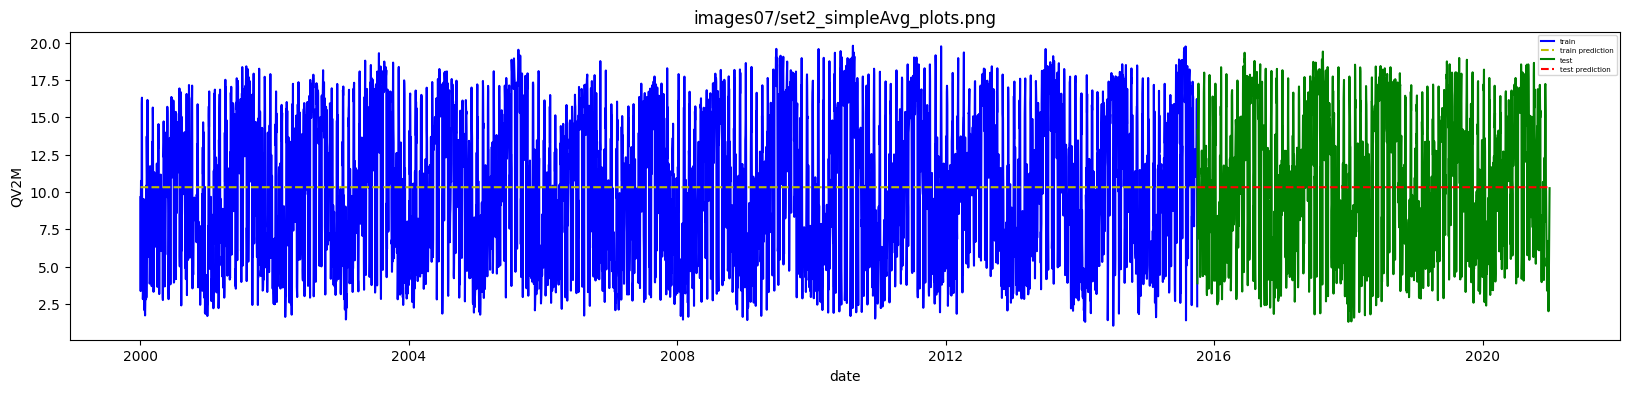

In [ ]:
from sklearn.base import RegressorMixin
from ts_functions import PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series

file_tag = 'set2'

class SimpleAvgRegressor (RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean = 0

    def fit(self, X: DataFrame):
        self.mean = X.mean()

    def predict(self, X: DataFrame):
        prd =  len(X) * [self.mean]
        return prd

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['SimpleAvg'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images07/{file_tag}_simpleAvg_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images07/{file_tag}_simpleAvg_plots.png', x_label=index_col, y_label=target)

### Rolling Mean

In [ ]:
from matplotlib.pyplot import subplots, show, savefig
from ds_charts import multiple_line_chart
from ts_functions import HEIGHT, PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series
from matplotlib.pyplot import plot, scatter

class RollingMeanRegressor (RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win

    def fit(self, X: DataFrame):
        None

    def predict(self, X: DataFrame):
        prd = len(X) * [0]
        for i in range(len(X)):
            prd[i] = X[max(0, i-self.win_size+1):i+1].mean()
        return prd


measure = 'R2'
flag_pct = False
results = []

windows = [3, 5, 10, 20, 50]
ncols = len(windows)

for win in windows:
    fr_mod = RollingMeanRegressor(win)
    fr_mod.fit(train)
    prd_trn = fr_mod.predict(train)
    prd_tst = fr_mod.predict(test)
    results.append(PREDICTION_MEASURES[measure](test.values, prd_tst))

print(results)

[0.7112414393397168, 0.4795724505248816, 0.2963858300248502, 0.1993226569615596, 0.1922250370678088]


best:  3


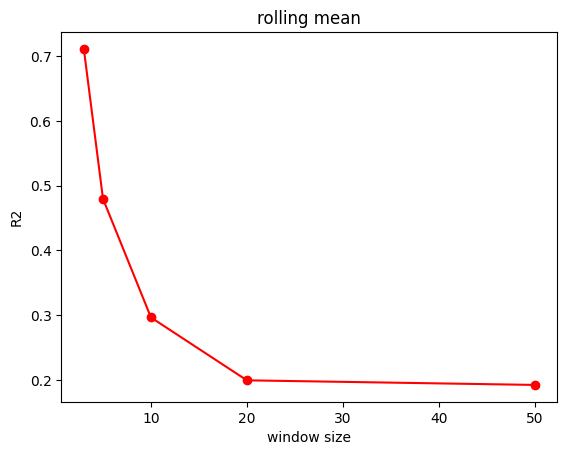

In [ ]:
from matplotlib.pyplot import plot, scatter

best_result = max(results)
best_index = results.index(best_result)
best_window = windows[best_index]
print('best: ', best_window)

plt.plot(windows, results, '-ro')
plt.xlabel('window size')
plt.ylabel('R2')
plt.title('rolling mean')

plt.show()

3
{'SimpleAvg': -0.01301511571547831, 'RollingMean': 0.7112414393397168}
{'RMSE': [2.4869351390704915, 2.4891559448551837], 'MAE': [1.840335187438438, 1.849998262078554]} {'R2': [0.7196223188590263, 0.7112414393397168]}


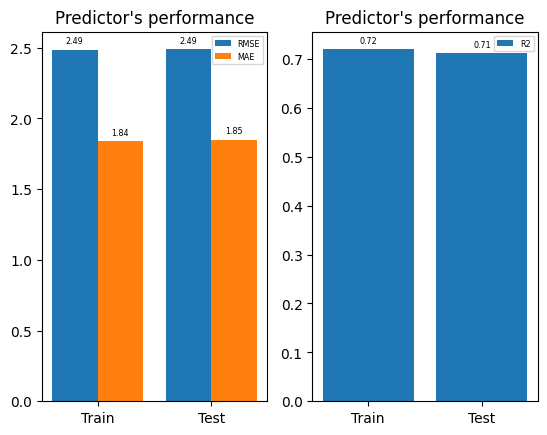

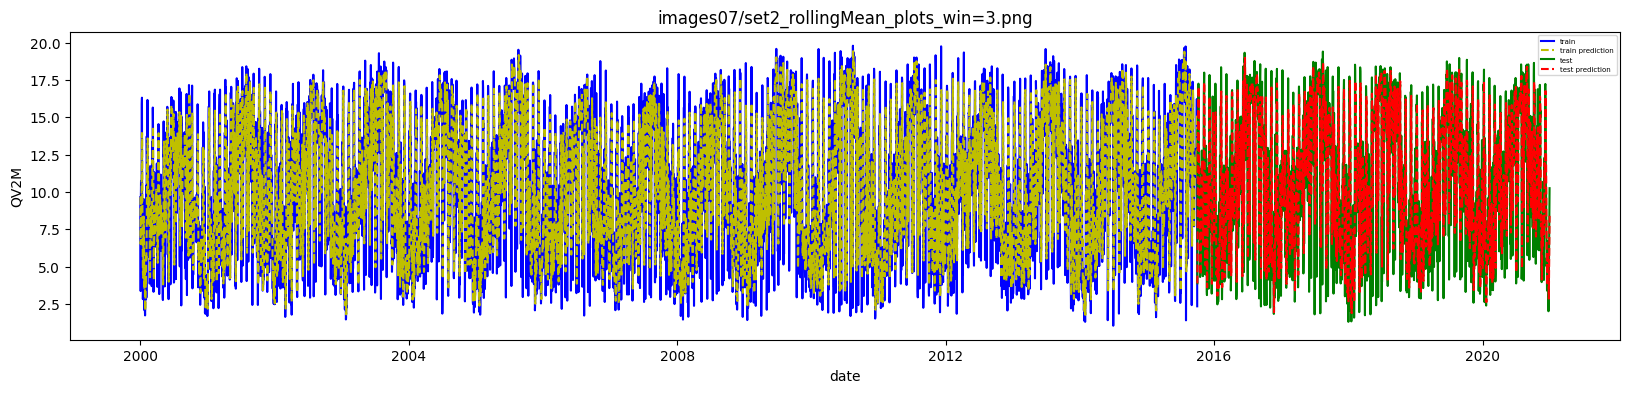

In [ ]:
class RollingMeanRegressor (RegressorMixin):
    def __init__(self, win: int = 3):
        print(win)
        super().__init__()
        self.win_size = win

    def fit(self, X: DataFrame):
        None

    def predict(self, X: DataFrame):
        prd = len(X) * [0]
        for i in range(len(X)):
            prd[i] = X[max(0, i-self.win_size+1):i+1].mean()
        return prd

window = best_window

fr_mod = RollingMeanRegressor(window)
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['RollingMean'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images07/{file_tag}_rollingMean_eval_win={window}.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images07/{file_tag}_rollingMean_plots_win={window}.png', x_label=index_col, y_label=target)

### ARIMA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


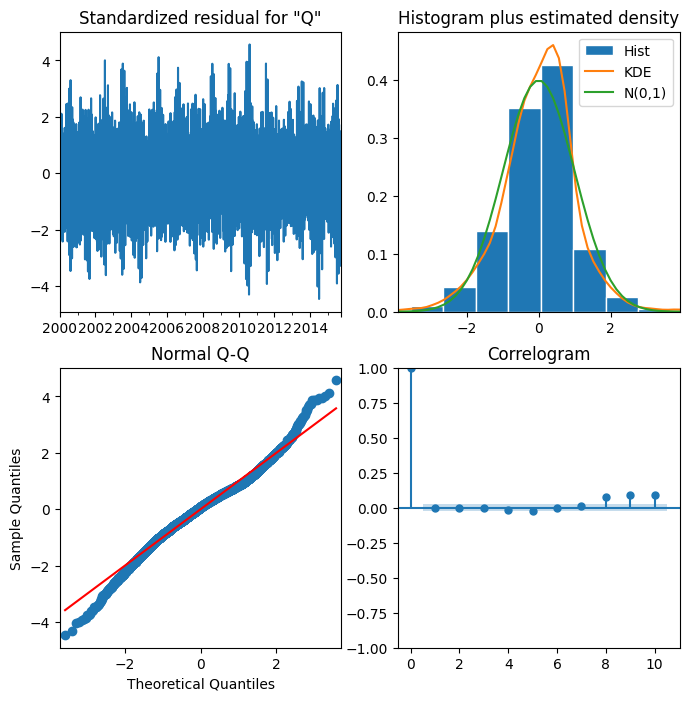

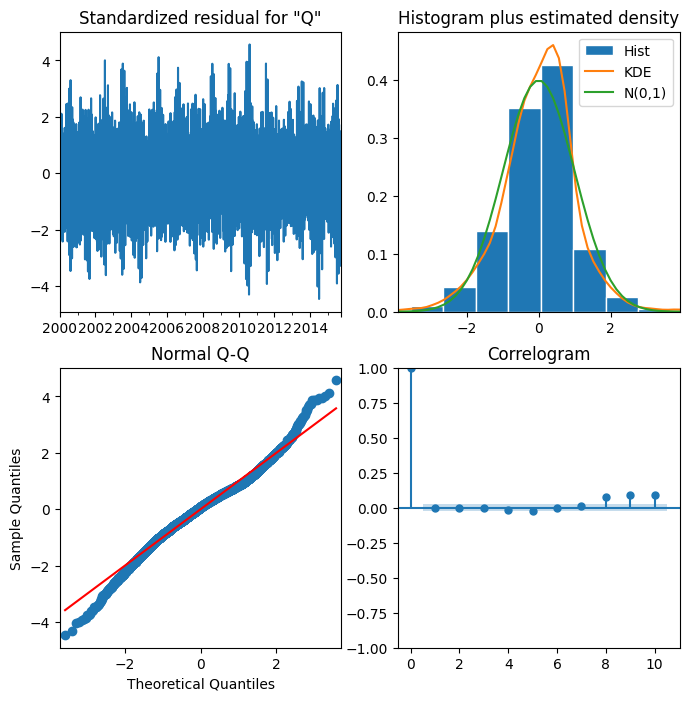

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

pred = ARIMA(train, order=(2, 0, 2))
model = pred.fit(method_kwargs={'warn_convergence': False})
model.plot_diagnostics(figsize=(2*HEIGHT, 2*HEIGHT))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.frame

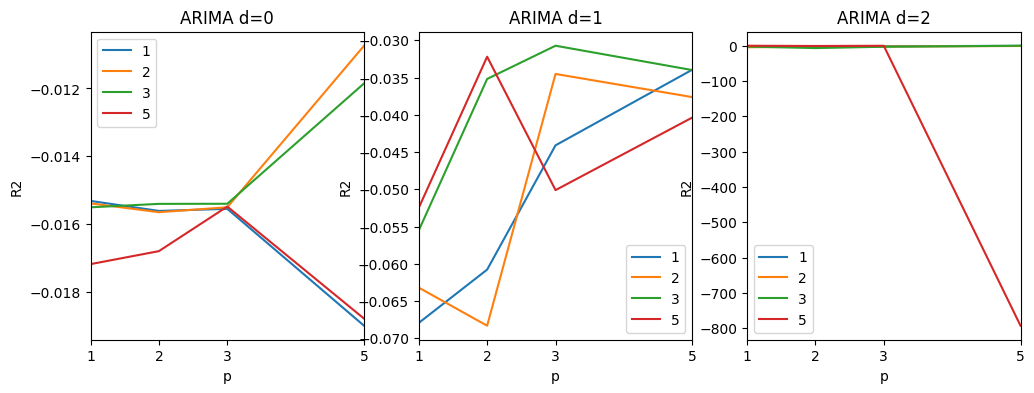

Best results achieved with (p,d,q)=(5, 0, 2) ==> measure=-0.01


In [ ]:
from matplotlib.pyplot import subplots, show, savefig
from ds_charts import multiple_line_chart
from ts_functions import HEIGHT, PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series

measure = 'R2'
flag_pct = False
last_best = -100
best = ('',  0, 0.0)
best_model = None

d_values = (0, 1, 2)
params = (1, 2, 3, 5)
ncols = len(d_values)

fig, axs = subplots(1, ncols, figsize=(ncols*HEIGHT, HEIGHT), squeeze=False)

for der in range(len(d_values)):
    d = d_values[der]
    values = {}
    for q in params:
        yvalues = []
        for p in params:
            pred = ARIMA(train, order=(p, d, q))
            model = pred.fit(method_kwargs={'warn_convergence': False})
            prd_tst = model.forecast(steps=len(test), signal_only=False)
            yvalues.append(PREDICTION_MEASURES[measure](test,prd_tst))
            if yvalues[-1] > last_best:
                best = (p, d, q)
                last_best = yvalues[-1]
                best_model = model
        values[q] = yvalues
    multiple_line_chart(
        params, values, ax=axs[0, der], title=f'ARIMA d={d}', xlabel='p', ylabel=measure, percentage=flag_pct)
#savefig(f'images/{file_tag}_ts_arima_study.png')
show()
print(f'Best results achieved with (p,d,q)=({best[0]}, {best[1]}, {best[2]}) ==> measure={last_best:.2f}')

	R2=-0.010743043487916326
{'RMSE': [3.2055885363703913, 4.656987284890311], 'MAE': [2.430266490152448, 4.038866095252945]} {'R2': [0.5341671890715948, -0.010743043487916326]}


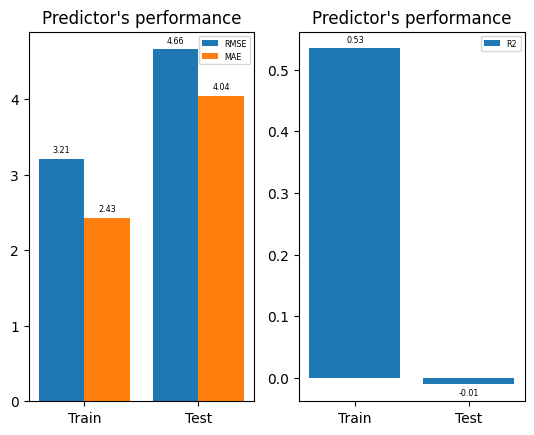

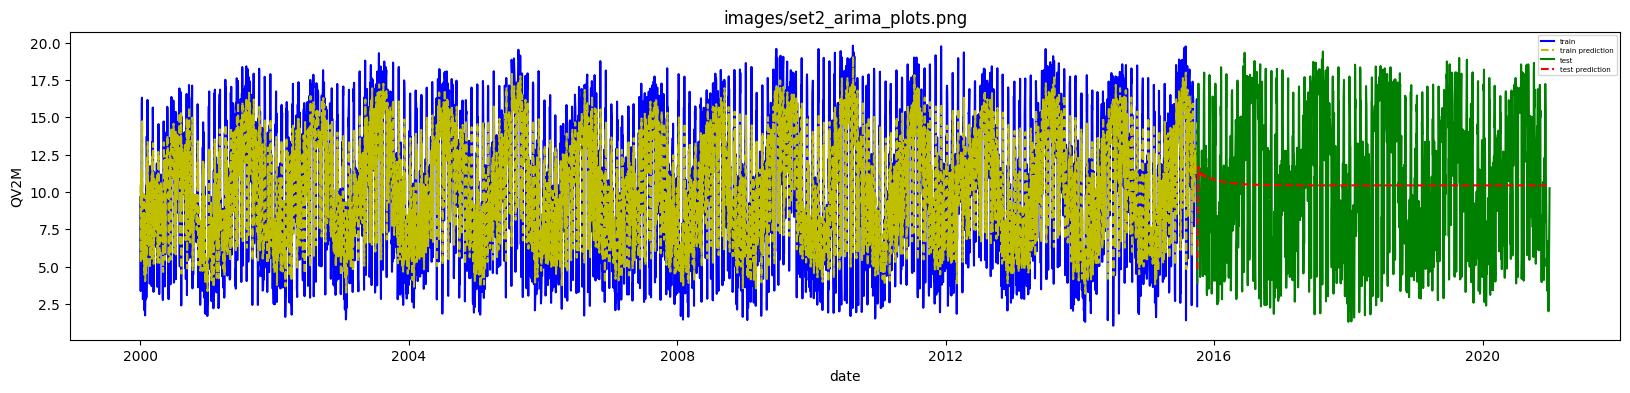

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from ts_functions import PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series

prd_trn = best_model.predict(start=0, end=len(train)-1)
prd_tst = best_model.forecast(steps=len(test))
print(f'\t{measure}={PREDICTION_MEASURES[measure](test, prd_tst)}')

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/{file_tag}_arima_eval.png')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/{file_tag}_arima_plots.png', x_label= str(index), y_label=str(target))

#### LSMTs

In [ ]:
from torch import zeros
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.autograd import Variable

class DS_LSTM(Module):
    def __init__(self, input_size, hidden_size, learning_rate, num_layers=1, num_classes=1):
        super(DS_LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = Linear(hidden_size, self.num_classes)
        self.criterion = MSELoss()    # mean-squared error for regression
        self.optimizer = Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        h_0 = Variable(zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(zeros(
            self.num_layers, x.size(0), self.hidden_size))
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

    def fit(self, trainX, trainY):
        # Train the model
        outputs = self(trainX)
        self.optimizer.zero_grad()
        # obtain the loss function
        loss = self.criterion(outputs, trainY)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, data):
        # Predict the target variable for the input data
        return self(data).detach().numpy()

In [ ]:
from pandas import read_csv, DataFrame
from torch import manual_seed, Tensor
from torch.autograd import Variable
from ts_functions import split_dataframe, sliding_window
from sklearn.preprocessing import MinMaxScaler

train, test = split_dataframe(data, trn_pct=.70)
nr_features = len(data.columns)

seq_length = 4
num_epochs = 2000

trnX, trnY = sliding_window(train, seq_length = seq_length)
trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
tstX, tstY = sliding_window(test, seq_length = seq_length)
tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))

my_lstm = DS_LSTM(input_size=1, hidden_size=8, learning_rate=0.001)

for epoch in range(num_epochs+1):
    loss = my_lstm.fit(trnX, trnY)
    if epoch % 500 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss))


Epoch: 0, loss: 130.11258
Epoch: 500, loss: 43.33744
Epoch: 1000, loss: 23.78078
Epoch: 1500, loss: 15.60339
Epoch: 2000, loss: 12.63531


In [ ]:
from sklearn.metrics import r2_score

prd_trn = my_lstm(trnX)
prd_tst = my_lstm(tstX)

print('TRAIN R2=', r2_score(trnY.data.numpy(), prd_trn.data.numpy()))
print('TEST R2=', r2_score(tstY.data.numpy(), prd_tst.data.numpy()))

TRAIN R2= 0.4244943541325652
TEST R2= 0.3809683102567346


LSTM - seq length=4 hidden_units=8 and nr_episodes=500->-0.67
LSTM - seq length=4 hidden_units=8 and nr_episodes=1000->0.03
LSTM - seq length=4 hidden_units=8 and nr_episodes=2500->0.49
LSTM - seq length=4 hidden_units=8 and nr_episodes=5000->0.54
LSTM - seq length=4 hidden_units=16 and nr_episodes=500->-0.24
LSTM - seq length=4 hidden_units=16 and nr_episodes=1000->0.34
LSTM - seq length=4 hidden_units=16 and nr_episodes=2500->0.53
LSTM - seq length=4 hidden_units=16 and nr_episodes=5000->0.54
LSTM - seq length=4 hidden_units=32 and nr_episodes=500->0.41
LSTM - seq length=4 hidden_units=32 and nr_episodes=1000->0.51
LSTM - seq length=4 hidden_units=32 and nr_episodes=2500->0.55
LSTM - seq length=4 hidden_units=32 and nr_episodes=5000->0.54
LSTM - seq length=20 hidden_units=8 and nr_episodes=500->-1.19
LSTM - seq length=20 hidden_units=8 and nr_episodes=1000->-0.17
LSTM - seq length=20 hidden_units=8 and nr_episodes=2500->0.47
LSTM - seq length=20 hidden_units=8 and nr_episodes=5000->0

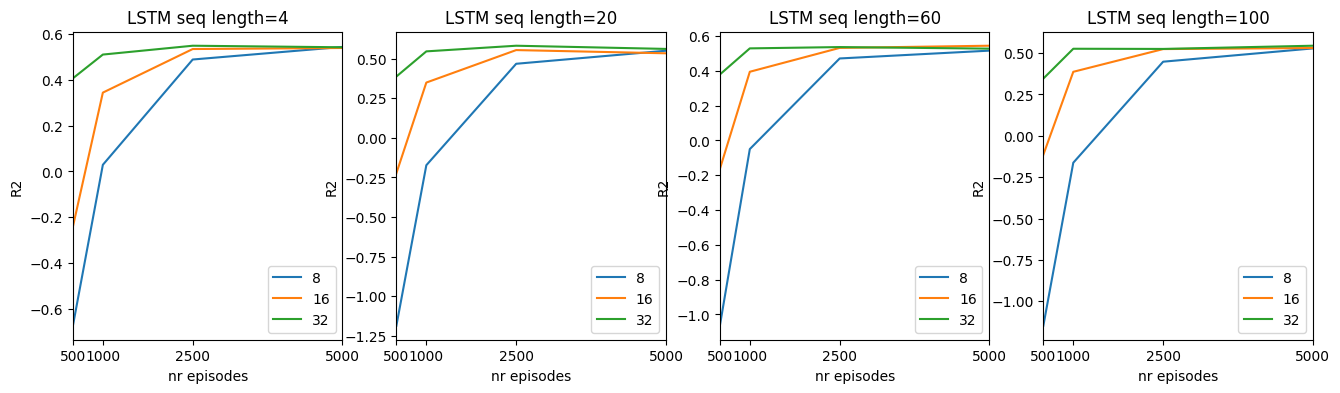

In [ ]:
from torch import manual_seed, Tensor
from torch.autograd import Variable
from ds_charts import HEIGHT, multiple_line_chart
from matplotlib.pyplot import subplots, show, savefig
from ts_functions import PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series, sliding_window

best = ('',  0, 0.0)
last_best = -100
best_model = None

measure = 'R2'
flag_pct = False

learning_rate = 0.001
sequence_size = [4, 20, 60, 100]
nr_hidden_units = [8, 16, 32]
max_iter = [500, 500, 1500, 2500]
episode_values = [max_iter[0]]
for el in max_iter[1:]:
    episode_values.append(episode_values[-1]+el)

nCols = len(sequence_size)
_, axs = subplots(1, nCols, figsize=(nCols*HEIGHT, HEIGHT), squeeze=False)
values = {}
for s in range(len(sequence_size)):
    length = sequence_size[s]
    trnX, trnY = sliding_window(train, seq_length = length)
    trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
    tstX, tstY = sliding_window(test, seq_length = length)
    tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))

    for k in range(len(nr_hidden_units)):
        hidden_units = nr_hidden_units[k]
        yvalues = []
        model = DS_LSTM(input_size=nr_features, hidden_size=hidden_units, learning_rate=learning_rate)
        next_episode_i = 0
        for n in range(1, episode_values[-1]+1):
            model.fit(trnX, trnY)
            if n == episode_values[next_episode_i]:
                next_episode_i += 1
                prd_tst = model.predict(tstX)
                yvalues.append((PREDICTION_MEASURES[measure])(tstY, prd_tst))
                print((f'LSTM - seq length={length} hidden_units={hidden_units} and nr_episodes={n}->{yvalues[-1]:.2f}'))
                if yvalues[-1] > last_best:
                    best = (length, hidden_units, n)
                    last_best = yvalues[-1]
                    best_model = model
        values[hidden_units] = yvalues

    multiple_line_chart(
        episode_values, values, ax=axs[0, s], title=f'LSTM seq length={length}', xlabel='nr episodes', ylabel=measure, percentage=flag_pct)
print(f'Best results with seq length={best[0]} hidden={best[1]} episodes={best[2]} ==> measure={last_best:.2f}')
savefig(f'images/{file_tag}_lstm_study.png')
show()

{'RMSE': [2.388028798285915, 3.1021208368668423], 'MAE': [1.8060308, 2.319702]} {'R2': [0.7402960233848631, 0.560464028673626]}


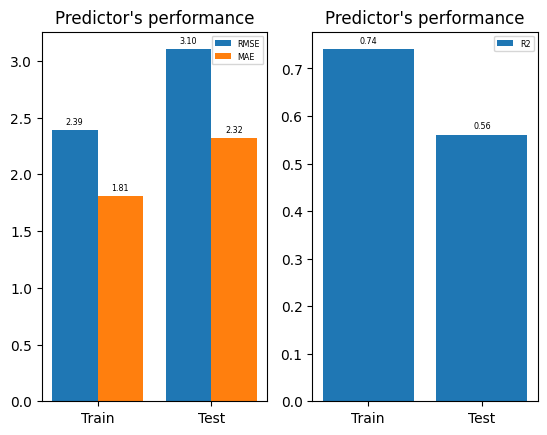

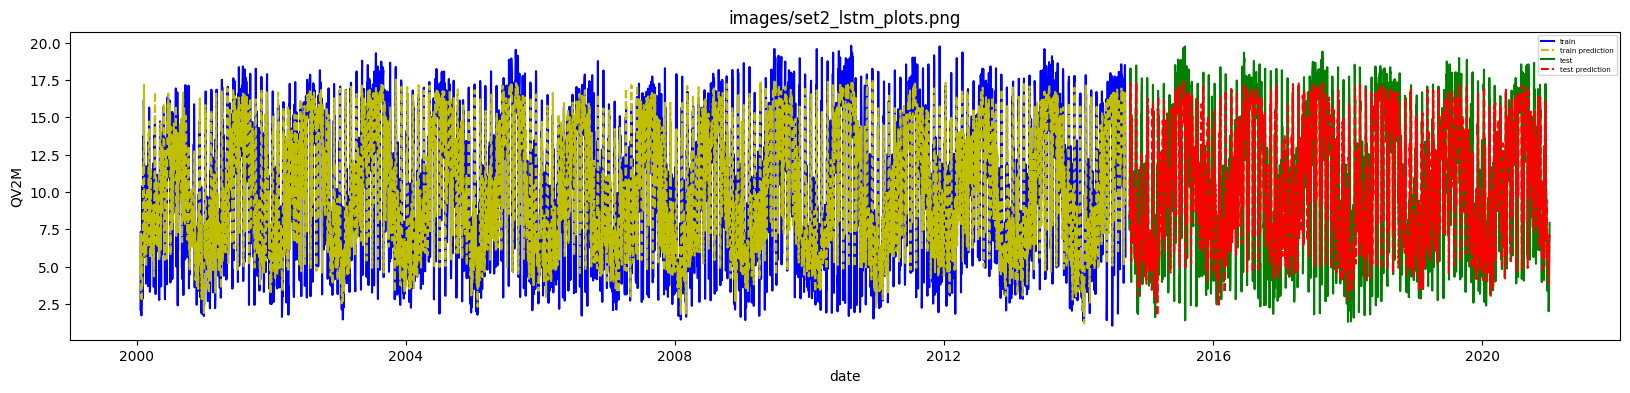

In [ ]:
trnX, trnY = sliding_window(train, seq_length = best[0])
trainY = DataFrame(trnY)
trainY.index = train.index[best[0]+1:]
trainY.columns = [target]
trnX, trnY  = Variable(Tensor(trnX)), Variable(Tensor(trnY))
prd_trn = best_model.predict(trnX)
prd_trn = DataFrame(prd_trn)
prd_trn.index=train.index[best[0]+1:]
prd_trn.columns = [target]

tstX, tstY = sliding_window(test, seq_length = best[0])
testY = DataFrame(tstY)
testY.index = test.index[best[0]+1:]
testY.columns = [target]
tstX, tstY  = Variable(Tensor(tstX)), Variable(Tensor(tstY))
prd_tst = best_model.predict(tstX)
prd_tst = DataFrame(prd_tst)
prd_tst.index=test.index[best[0]+1:]
prd_tst.columns = [target]

plot_evaluation_results(trnY.data.numpy(), prd_trn, tstY.data.numpy(), prd_tst, f'images/{file_tag}_lstm_eval.png')
show()
plot_forecasting_series(trainY, testY, prd_trn.values, prd_tst.values, f'images/{file_tag}_lstm_plots.png', x_label=index_col, y_label=target)
show()